In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision scikit-learn seaborn tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Copy dataset to local Colab storage

!cp -r /content/drive/MyDrive/PCB_Dataset/output_defect_rois /content/data_local

In [ ]:
DATASET_ROOT = "/content/data_local"

In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std =[0.229,0.224,0.225]
    )
])


test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std =[0.229,0.224,0.225]
    )
])


In [ ]:
full_dataset = datasets.ImageFolder(DATASET_ROOT)

class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total images:", len(full_dataset))


Classes: ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']
Total images: 6201


In [ ]:
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size

train_idx, test_idx = random_split(
    range(len(full_dataset)),
    [train_size, test_size]
)


train_dataset = torch.utils.data.Subset(
    datasets.ImageFolder(DATASET_ROOT, transform=train_transform),
    train_idx
)

test_dataset = torch.utils.data.Subset(
    datasets.ImageFolder(DATASET_ROOT, transform=test_transform),
    test_idx
)

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory= False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Replace classifier
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    num_classes
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)

# Freeze Backbone (Phase 1)
for param in model.features.parameters():
    param.requires_grad = False

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.classifier.parameters(),
    lr=3e-4
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 178MB/s]


Using device: cuda


In [ ]:
def train_model(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs,1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = 100 * correct / total

    return running_loss/len(loader), acc

In [ ]:
EPOCHS = 30
print("\n--- Phase 1 Training ---\n")
for epoch in range(EPOCHS):
    loss, acc = train_model(
        model,
        train_loader,
        optimizer,
        criterion
    )
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Loss: {loss:.4f} "
        f"Acc: {acc:.2f}%"
    )


--- Phase 1 Training ---

Epoch [1/30] Loss: 1.3675 Acc: 45.85%
Epoch [2/30] Loss: 1.0528 Acc: 60.65%
Epoch [3/30] Loss: 0.9360 Acc: 64.17%
Epoch [4/30] Loss: 0.8602 Acc: 65.69%
Epoch [5/30] Loss: 0.8242 Acc: 66.81%
Epoch [6/30] Loss: 0.7948 Acc: 67.54%
Epoch [7/30] Loss: 0.7796 Acc: 68.10%
Epoch [8/30] Loss: 0.7593 Acc: 67.82%
Epoch [9/30] Loss: 0.7538 Acc: 68.65%
Epoch [10/30] Loss: 0.7324 Acc: 69.13%
Epoch [11/30] Loss: 0.7141 Acc: 69.90%
Epoch [12/30] Loss: 0.7085 Acc: 69.96%
Epoch [13/30] Loss: 0.7024 Acc: 69.40%
Epoch [14/30] Loss: 0.7112 Acc: 69.54%
Epoch [15/30] Loss: 0.6865 Acc: 71.15%
Epoch [16/30] Loss: 0.6947 Acc: 69.52%
Epoch [17/30] Loss: 0.6702 Acc: 70.69%
Epoch [18/30] Loss: 0.6918 Acc: 69.52%
Epoch [19/30] Loss: 0.6843 Acc: 70.40%
Epoch [20/30] Loss: 0.6618 Acc: 71.19%
Epoch [21/30] Loss: 0.6682 Acc: 70.60%
Epoch [22/30] Loss: 0.6585 Acc: 71.09%
Epoch [23/30] Loss: 0.6527 Acc: 71.09%
Epoch [24/30] Loss: 0.6641 Acc: 71.23%
Epoch [25/30] Loss: 0.6652 Acc: 70.73%
Epoch [

In [ ]:
for param in model.features[-3:].parameters():
    param.requires_grad = True

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-5
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    patience=2
)

In [ ]:
EPOCHS_PHASE2 = 20

for epoch in range(EPOCHS_PHASE2):

    loss, acc = train_model(
        model,
        train_loader,
        optimizer,
        criterion
    )

    scheduler.step(loss)

    print(
        f"Fine Epoch [{epoch+1}/{EPOCHS_PHASE2}] "
        f"Loss: {loss:.4f} "
        f"Acc: {acc:.2f}% "
        f"LR: {optimizer.param_groups[0]['lr']}"
    )

Fine Epoch [1/20] Loss: 0.6307 Acc: 71.90% LR: 1e-05
Fine Epoch [2/20] Loss: 0.6008 Acc: 72.98% LR: 1e-05
Fine Epoch [3/20] Loss: 0.5813 Acc: 73.87% LR: 1e-05
Fine Epoch [4/20] Loss: 0.5582 Acc: 75.04% LR: 1e-05
Fine Epoch [5/20] Loss: 0.5442 Acc: 75.38% LR: 1e-05
Fine Epoch [6/20] Loss: 0.5397 Acc: 75.52% LR: 1e-05
Fine Epoch [7/20] Loss: 0.5137 Acc: 76.79% LR: 1e-05
Fine Epoch [8/20] Loss: 0.5125 Acc: 77.46% LR: 1e-05
Fine Epoch [9/20] Loss: 0.5103 Acc: 77.12% LR: 1e-05
Fine Epoch [10/20] Loss: 0.4958 Acc: 77.76% LR: 1e-05
Fine Epoch [11/20] Loss: 0.4898 Acc: 78.04% LR: 1e-05
Fine Epoch [12/20] Loss: 0.4679 Acc: 79.38% LR: 1e-05
Fine Epoch [13/20] Loss: 0.4694 Acc: 79.46% LR: 1e-05
Fine Epoch [14/20] Loss: 0.4722 Acc: 78.23% LR: 1e-05
Fine Epoch [15/20] Loss: 0.4579 Acc: 78.71% LR: 1e-05
Fine Epoch [16/20] Loss: 0.4467 Acc: 80.10% LR: 1e-05
Fine Epoch [17/20] Loss: 0.4370 Acc: 80.46% LR: 1e-05
Fine Epoch [18/20] Loss: 0.4361 Acc: 80.54% LR: 1e-05
Fine Epoch [19/20] Loss: 0.4282 Acc: 

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/PCB_Dataset/efficientnet_pcb.pth"

torch.save(model.state_dict(), MODEL_PATH)

print("Model saved at:", MODEL_PATH)

Model saved at: /content/drive/MyDrive/PCB_Dataset/efficientnet_pcb.pth


In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():

    for images, labels in test_loader:

        images = images.to(device)

        outputs = model(images)

        _, preds = torch.max(outputs,1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

In [ ]:
print("\nClassification Report:\n")

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


Classification Report:

                 precision    recall  f1-score   support

   Missing_hole       1.00      1.00      1.00        88
     Mouse_bite       0.94      0.83      0.88       107
   Open_circuit       0.85      0.94      0.89        98
          Short       0.91      0.88      0.90        95
           Spur       0.67      0.65      0.66       350
Spurious_copper       0.77      0.79      0.78       503

       accuracy                           0.79      1241
      macro avg       0.86      0.85      0.85      1241
   weighted avg       0.79      0.79      0.79      1241



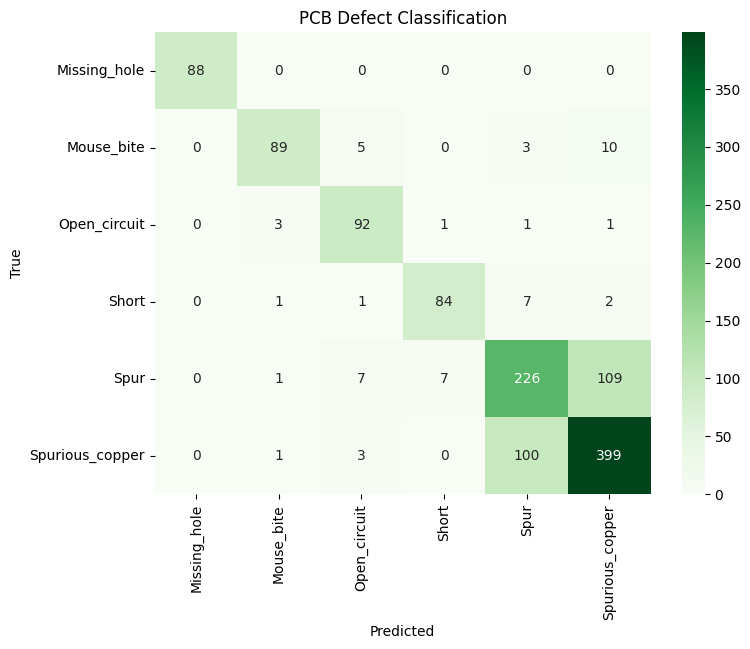

In [ ]:
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8,6))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("PCB Defect Classification")

plt.show()

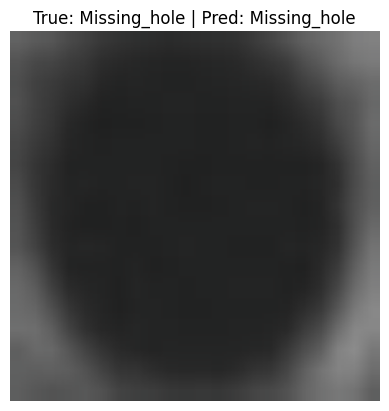

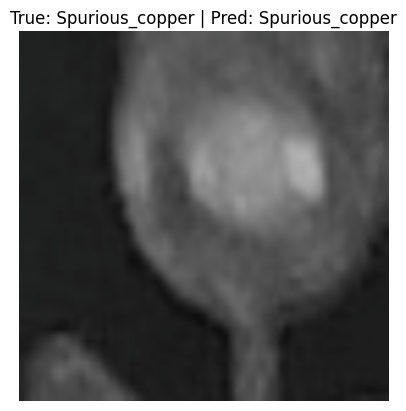

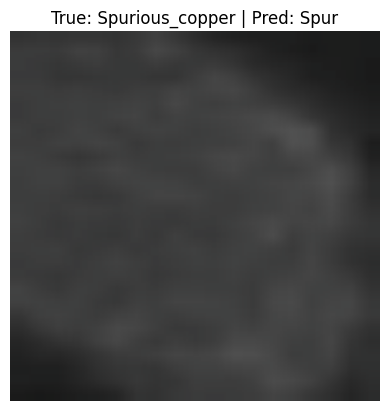

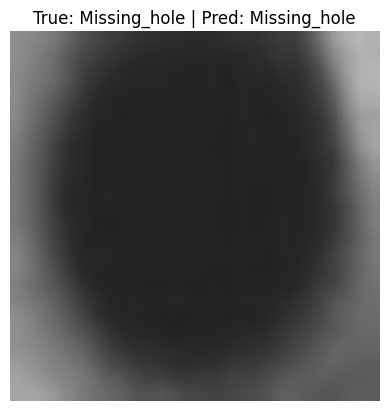

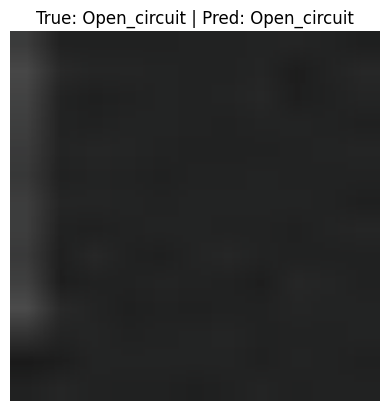

In [ ]:
import random
import numpy as np

# Imagenet normalization values
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

for i in random.sample(range(len(test_dataset)), 5):
    img, label = test_dataset[i]
    img_input = img.unsqueeze(0).to(device)
    output = model(img_input)
    _, pred = torch.max(output,1)
    # ---- Unnormalize ----
    img = img.permute(1,2,0).cpu().numpy()
    img = std * img + mean     # reverse normalization
    img = np.clip(img,0,1)    # keep valid range
    plt.imshow(img)
    plt.title(
        f"True: {class_names[label]} | Pred: {class_names[pred.item()]}"
    )

    plt.axis("off")
    plt.show()